# *Chapter - 3*

## PART - 1 - Text based RAG

### Installations

In [7]:
%%capture
!pip install langchain langchain-openai pypdf openai chromadb tiktoken docx2txt

In [1]:
import os
import sys
from dotenv import load_dotenv
from langchain.chains import ConversationalRetrievalChain
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, TextLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Load environment variables
load_dotenv('.env')

True

In [2]:
documents = []

# Function to safely load documents
def safe_load_documents(loader, file_path):
    try:
        return loader(file_path).load()
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return []

# Create a List of Documents from all of our files in the ./docs folder
for file in os.listdir("textual_dataset"):
    if file.endswith(".pdf"):
        pdf_path = f"./textual_dataset/{file}"
        documents.extend(safe_load_documents(PyPDFLoader, pdf_path))
    elif file.endswith('.docx') or file.endswith('.doc'):
        doc_path = f"./textual_dataset/{file}"
        documents.extend(safe_load_documents(Docx2txtLoader, doc_path))
    elif file.endswith('.txt'):
        text_path = f"./textual_dataset/{file}"
        print(text_path)
        documents.extend(safe_load_documents(TextLoader, text_path))

In [3]:
# Split the documents into smaller chunks
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=10)
documents = text_splitter.split_documents(documents)

# Filter out empty or invalid chunks
documents = [doc for doc in documents if doc.page_content.strip()]
if not documents:
    print("No valid documents found after processing.")
    sys.exit()

In [5]:
# # Convert the document chunks to embeddings and save them to the vector store
# vectordb = Chroma.from_documents(
#     documents,
#     embedding=OpenAIEmbeddings(),
#     persist_directory="./textual_dataset_chromaDB"
# )

In [4]:
# Reload the persisted vector store
vectordb = Chroma(
    persist_directory="./textual_dataset_chromaDB",  # Directory where the vector store was saved
    embedding_function=OpenAIEmbeddings()  # Same embedding function used during saving
)

C:\Users\charu\AppData\Local\Temp\ipykernel_4336\2369885297.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(


In [5]:
# Create our Q&A chain
pdf_qa = ConversationalRetrievalChain.from_llm(
    ChatOpenAI(temperature=0.7, model_name='gpt-3.5-turbo'),
    retriever=vectordb.as_retriever(search_kwargs={'k': 6}),
    return_source_documents=True,
    verbose=False
)

In [10]:
chat_history = []
print("-------------------------------------------------------------------------------------")
print('Welcome to DocBot. You are ready to start interacting with your documents!')
print('-------------------------------------------------------------------------------------')
while True:
    query = input(f"Prompt: ")
    if query == "exit" or query == "quit" or query == "q" or query == "f":
        print('Exiting')
        sys.exit()
    if query == '':
        continue
    result = pdf_qa.invoke(
        {"question": query, "chat_history": chat_history})
    print(f"Answer: " + result["answer"])
    # chat_history.append((query, result["answer"]))

-------------------------------------------------------------------------------------
Welcome to DocBot. You are ready to start interacting with your documents!
-------------------------------------------------------------------------------------


Prompt:  What is the young man doing on the tennis court?


Answer: The young man is playing tennis.


Prompt:  q


Exiting


SystemExit: 

C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Visualize Chroma DB Embeddings

In [ ]:
%%capture
!pip install numpy matplotlib scikit-learn

In [7]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Load the persisted vector store
vectordb = Chroma(
    persist_directory="./textual_dataset_chromaDB",  # Directory where your vector store is saved
    embedding_function=OpenAIEmbeddings()  # Same embedding function
)

# Access the Chroma collection
collection = vectordb._collection

# Fetch all embeddings and metadata
data = collection.get(include=['embeddings', 'documents', 'metadatas'])
all_embeddings = np.array(data.get("embeddings", [])) # Extract embeddings as numpy array
all_metadata = data.get("metadatas", [])

# Validate embeddings
if (all_embeddings.shape) == 0:
    raise ValueError("No embeddings found in the vector store.")

In [13]:
all_embeddings.shape

(534, 1536)

In [15]:
# print(collection.get(include=['embeddings', 'documents', 'metadatas']))

In [8]:
# Dimensionality reduction using t-SNE
perplexity = min(30, (all_embeddings.size) - 1)  # Perplexity must be less than the number of samples
print(f"Reducing dimensions with t-SNE (perplexity={perplexity})...")
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=1000)
embeddings_2d = tsne.fit_transform(all_embeddings)

Reducing dimensions with t-SNE (perplexity=30)...


C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


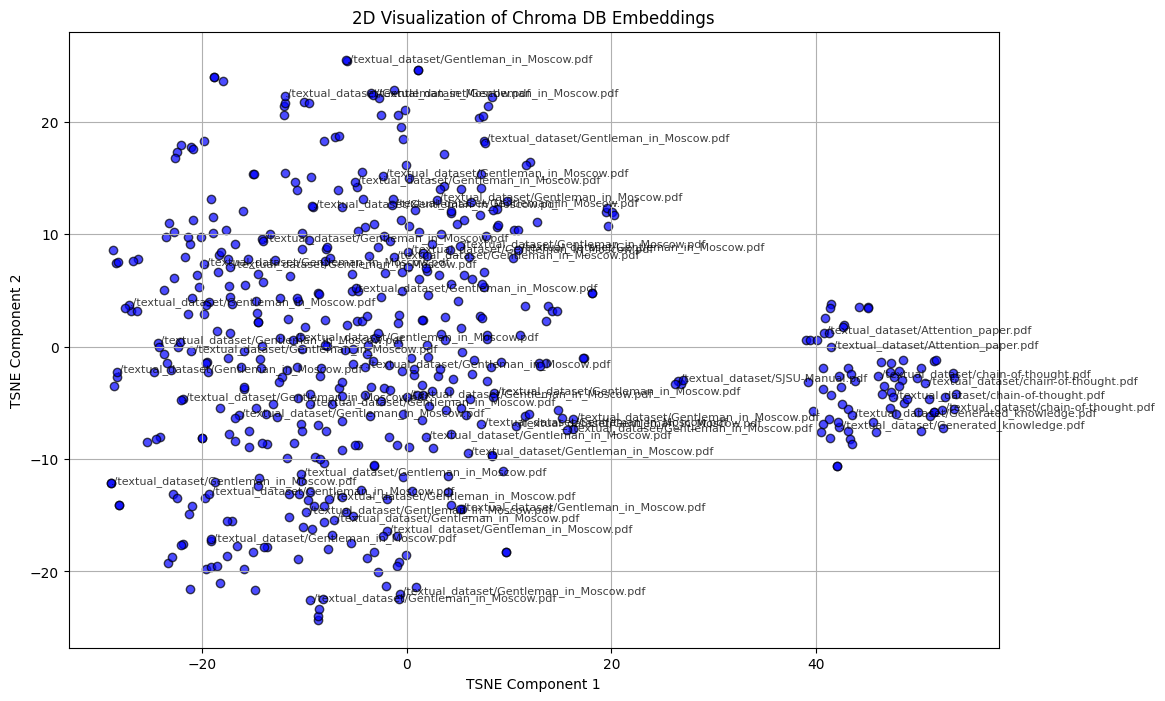

In [9]:
# Plotting the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c='blue',
    edgecolor='k',
    alpha=0.7
)

# Annotate some points with metadata
for i, metadata in enumerate(all_metadata):
    if i % 10 == 0:  # Annotate every 10th point to avoid clutter
        plt.annotate(metadata.get("source", f"Doc {i}"), 
                     (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     fontsize=8, alpha=0.75)

plt.title("2D Visualization of Chroma DB Embeddings")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.grid(True)
plt.show()

In [90]:
%%capture
!pip install umap-learn

In [11]:
sample_size = 1000
sampled_indices = np.random.choice(len(all_embeddings), size=sample_size)
all_embeddings = all_embeddings[sampled_indices]
all_metadata = [all_metadata[i] for i in sampled_indices]

In [16]:
from umap import UMAP
umap = UMAP(n_components=2, random_state=42)
embeddings_2d = umap.fit_transform(all_embeddings)

C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


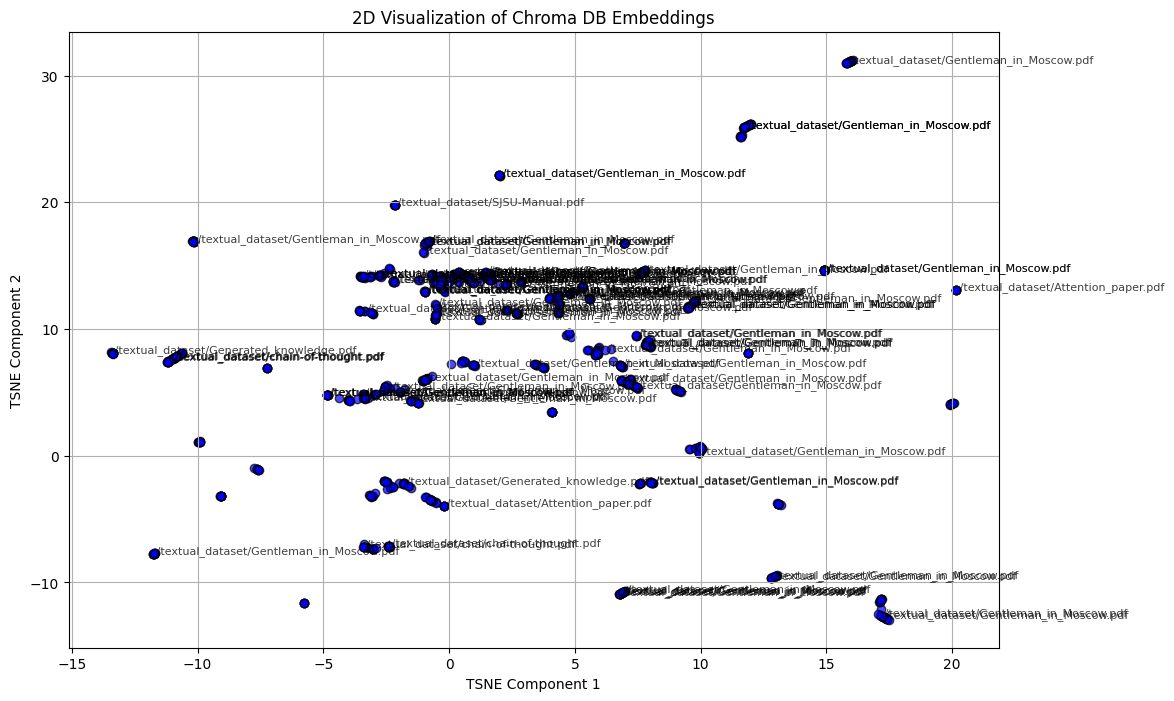

In [13]:
# Plotting the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c='blue',
    edgecolor='k',
    alpha=0.7
)

# Annotate some points with metadata
for i, metadata in enumerate(all_metadata):
    if i % 10 == 0:  # Annotate every 10th point to avoid clutter
        plt.annotate(metadata.get("source", f"Doc {i}"), 
                     (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     fontsize=8, alpha=0.75)

plt.title("2D Visualization of Chroma DB Embeddings")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.grid(True)
plt.show()

## Evaluation (Text + Tables)

In [1]:
%%capture
!pip install ragas 

In [14]:
import os
import openai
from ragas import evaluate
from datasets import Dataset 
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
# from ragas.metrics.critique import harmfulness
from langchain_community.vectorstores import Chroma
# from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.document_loaders import SeleniumURLLoader
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_correctness


In [15]:
PROMPT_TEMPLATE = """
Go through the context and answer given question strictly based on context. 
Context: {context}
Question: {question}
Answer:
"""

qa_chain = RetrievalQA.from_chain_type(
        llm = ChatOpenAI(temperature=0),
        retriever=vectordb.as_retriever(search_kwargs={'k': 3}),
        return_source_documents=True,
        chain_type_kwargs={"prompt": PromptTemplate.from_template(PROMPT_TEMPLATE)}
    )

In [22]:
queries = [
"What are the required components of a dissertation proposal in the SJSU Ed.D. program?",
"When is the literature review milestone completed during the doctoral program?",
"What happens if a student fails the oral defense of their dissertation?",
"What are the possible formats for a dissertation in the SJSU Ed.D. program?",
"How many units of dissertation credit are required in the final year?",
"What is the role of the Institutional Review Board (IRB) in the dissertation process?",
"Who can serve on a dissertation committee?",
"What are the key purposes of the final oral defense?",
"What resources are available for dissertation formatting guidelines?",
"What is the timeline for selecting a dissertation chair and committee?",
"What experience does Charul have with LangChain?",
"What is Charul's educational background?",
"What technologies does Charul have expertise in?",
"What project demonstrates Charul’s microservices expertise?",
"What was Charul's role at Société Générale?",
"What academic projects has Charul worked on?",
"How has Charul optimized performance in projects?",
"What experience does Charul have with OpenCV?",
"What was the focus of Charul’s role at ThermoFisher?",
"What are Charul’s programming language proficiencies?",
"What is the primary innovation of the Transformer model compared to previous architectures?",
"How does multi-head attention improve the Transformer model's performance?",
"What is the function of positional encodings in the Transformer?",
"Why is scaled dot-product attention used in the Transformer?",
"What are the two main sub-layers in the encoder of the Transformer?",
"How does the Transformer handle long-range dependencies compared to recurrent models?",
"What is the role of the encoder-decoder attention layer in the Transformer?",
"How does the Transformer achieve faster training compared to recurrent models?",
"What dataset was used to evaluate the Transformer on English-to-German translation tasks?",
"What BLEU score did the Transformer achieve on the English-to-German translation task?",
"What regularization techniques were used in training the Transformer?",
"What is the structure of the feed-forward network in the Transformer?",
"What are the advantages of the sinusoidal positional encodings over learned positional embeddings?",
"How does the Transformer handle auto-regression in the decoder?",
"What optimizer and learning rate schedule were used in the Transformer?",
"What is the main advantage of chain-of-thought prompting in large language models?",
"How does chain-of-thought prompting compare to standard prompting on the GSM8K benchmark?",
"What are the three primary reasoning tasks improved by chain-of-thought prompting?",
"How does chain-of-thought prompting facilitate interpretability in language models?",
"What scaling behavior is associated with chain-of-thought prompting?",
"What datasets were used to evaluate arithmetic reasoning performance?",
"Why is natural language reasoning beneficial in chain-of-thought prompting?",
"What are the limitations of chain-of-thought prompting noted in the paper?",
"What are the observed performance trends for symbolic reasoning tasks?",
"What methods were tested to isolate the benefits of chain-of-thought reasoning?",
"What prompts were used in commonsense reasoning benchmarks?",
"How does chain-of-thought prompting perform on tasks requiring background knowledge?",
"What prior work inspired the use of chain-of-thought prompting?",
"How does chain-of-thought prompting address variable computation needs?",
"What key observation is made about emergent abilities in large language models?",
"What is the main purpose of the Generated Knowledge Prompting (GKP) method?",
"What are the steps involved in the Generated Knowledge Prompting method?",
"How does GKP perform compared to retrieval-based methods?",
"What datasets were used to evaluate GKP?",
"What advantages does GKP provide for zero-shot models?",
"How does the size of the inference model affect GKP performance?",
"What role do few-shot demonstrations play in GKP?",
"How does GKP handle factuality in generated knowledge?",
"What are the key factors influencing the performance of GKP?",
"Can GKP integrate with fine-tuned models?",
"What is the main difference between GKP and template-based methods like self-talk?",
"How does GKP influence reasoning types in commonsense tasks?",
"What is the impact of knowledge quantity on GKP performance?",
"What are the limitations of GKP highlighted in the paper?",
"What are the potential risks of using GKP?",
"What was the sentence given to Count Alexander Ilyich Rostov by the committee?",
"What poem is associated with Count Rostov, and what is its significance?",
"What is the significance of Suite 317 in the story?",
"How does Count Rostov adapt to his new attic quarters?",
"How is the Metropol Hotel described in the narrative?",
"What does the Count do with his sister Helena’s portrait?",
"What is the role of the Metropol Hotel staff in the story?",
"What is the significance of the Count's desk?",
"How does Count Rostov maintain his dignity under house arrest?",
"What relationship does the Count have with the young girl in the hotel?",
"How is the Metropol Hotel a microcosm of Russian society?",
"What does the Count’s daily routine reveal about his character?",
"What is the significance of the wine Château de Baudelaire in the story?",
"How does Count Rostov view the concept of possessions?",
"What event disrupts the Count’s weekly visit to Yaroslav’s barbershop?",
"How does the Count react to the stranger cutting his mustache?",
"How does the story depict the changing role of aristocracy in Soviet Russia?",
"What role does the poem - Where Is It Now? - play during Count Rostov’s trial?",
"How does the Count view his life at the Metropol compared to his past?",
"How does the Count embody resilience in the face of adversity?",
]

In [23]:
ground_truths = [
    "The dissertation proposal includes a draft of the introduction, a preliminary literature review, methodology, and references. Students must present this proposal to their doctoral committee for approval, and approval is necessary before the data collection phase.",
    "The preliminary literature review is completed during the 2nd summer of the doctoral program as part of the EDD 591B course requirements.",
    "If the oral defense is unsatisfactory, the committee may require revisions or schedule a second defense after the student is adequately prepared.",
    "Students can choose from traditional formats (five chapters: introduction, literature review, methodology, results/analysis, conclusions/recommendations) or alternative formats like dissertations-in-practice, action research, and joint projects.",
    "Students must enroll in 12 units of dissertation credit during the final year, divided into 6 units for the fall and 6 units for the spring semesters.",
    "Students must submit their research proposal to the IRB for approval before starting data collection. The IRB evaluates ethical considerations in the proposed research.",
    "The dissertation committee comprises three members: two tenured/tenure-track faculty from SJSU (including the chair) and a third member with a terminal degree from the educational field.",
    "The final oral defense evaluates the quality of the dissertation, the student’s presentation skills, and their ability to share research findings with the academic community.",
    "Formatting guidelines are provided by the SJSU Graduate Studies division and reference APA style requirements.",
    "The dissertation chair is identified in the spring of the 2nd year, with the full committee formed by the summer of the same year."
    "During their internship at ThermoFisher Scientific, Charul built a Retrieval Augmented Generation (RAG) pipeline using LangChain, leveraging OpenAI APIs and ChromaDB vector store. Performance was evaluated using the RAGAS tool.",
    "Charul is pursuing an M.S. in Computer Science at San Jose State University with a GPA of 3.9/4 (Jan 2023 – Dec 2024) and holds a B.S. in Computer Science and Engineering from Mody University with a GPA of 4/4 (Jul 2014 – May 2018).",
    "Charul has skills in technologies like Microservices, RabbitMQ, Kafka, REST APIs, Spring Boot, Flask, Redis, MongoDB, Spark, MapReduce, AWS, Docker, Kubernetes, and CI/CD pipelines.",
    "In the FitFlair Clothing App project, Charul designed a distributed microservices architecture with Node.js and Spring Boot, integrating an API Gateway and Kafka for async communication, improving product catalog API load times by 65%.",
    "At Société Générale, Charul developed a C++ Value-at-Risk simulation framework, created an asset register microservice with Python and C++, and deployed it to Kubernetes, enabling seamless communication with RabbitMQ.",
    "Projects include AI teaches AI (SaaS AI Companion using Next.js, Pinecone, Redis, and Stripe APIs), FitFlair Clothing App (distributed microservices with Kafka), and Event Scheduler (Flask app on AWS with Google Auth).",
    "In the FitFlair Clothing App, Charul optimized API load times by caching in Redis, reducing response time from 500ms to 150ms, a 65% improvement.",
    "At Valeo, Charul developed a validation microservice for detecting counterfeit 3D patterns using Python, C++, OpenCV, and Fourier Transformations, achieving 98.4% accuracy in production.",
    "Charul focused on building a RAG pipeline with LangChain and OpenAI APIs, and developed a distributed encryption service in C++ for the Digital PCR Absolute Q tool, ensuring data integrity and security.",
    "Charul is proficient in C++, Python, Java, JavaScript, SQL, and HTML/CSS.",
    "The Transformer eliminates the need for recurrence and convolution in sequence transduction models, relying solely on self-attention mechanisms to model global dependencies.",
    "Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions, enabling richer feature extraction.",
    "Positional encodings inject information about the sequence order into the input embeddings since the Transformer lacks recurrence and convolution.",
    "Scaled dot-product attention normalizes the dot products to prevent the softmax function from entering regions with extremely small gradients when the dimensionality of keys is large.",
    "The encoder contains a multi-head self-attention mechanism and a position-wise fully connected feed-forward network, both with residual connections and layer normalization.",
    "The Transformer uses self-attention to directly connect all positions with a constant number of operations, significantly shortening the path for learning long-range dependencies.",
    "Encoder-decoder attention enables the decoder to attend to all positions in the encoder's output sequence, facilitating input-output alignment.",
    "By parallelizing computations across all sequence positions, the Transformer avoids the sequential nature of recurrent models, significantly reducing training time.",
    "The WMT 2014 English-to-German dataset with about 4.5 million sentence pairs was used for evaluation.",
    "The Transformer (big) model achieved a BLEU score of 28.4, surpassing previous state-of-the-art results.",
    "The Transformer used residual dropout, attention dropout, and label smoothing to prevent overfitting during training.",
    "Each feed-forward network consists of two linear transformations with a ReLU activation in between, applied independently to each position.",
    "Sinusoidal encodings allow the model to extrapolate to longer sequence lengths unseen during training, offering similar performance to learned embeddings.",
    "The Transformer masks future positions in the decoder’s self-attention mechanism to ensure predictions depend only on known outputs.",
    "The Adam optimizer was used with a learning rate schedule that increases linearly for the first 4000 steps and decreases proportionally to the inverse square root of the step number.",
    "Chain-of-thought prompting enables language models to decompose complex reasoning tasks into intermediate steps, improving their performance on arithmetic, commonsense, and symbolic reasoning tasks.",
    "Chain-of-thought prompting significantly outperforms standard prompting, achieving state-of-the-art results with PaLM 540B on the GSM8K benchmark for math word problems.",
    "Chain-of-thought prompting improves performance in arithmetic reasoning, commonsense reasoning, and symbolic reasoning.",
    "It provides a step-by-step reasoning process that allows users to debug the model’s reasoning path and understand how an answer was derived.",
    "The benefits of chain-of-thought prompting emerge only in sufficiently large models (approximately 100B parameters or more), with smaller models showing little to no performance improvement.",
    "The datasets include GSM8K, SVAMP, ASDiv, AQuA, and MAWPS.",
    "Natural language reasoning steps help translate complex problem semantics into manageable components, which is especially useful for challenging tasks like those in GSM8K.",
    "Chain-of-thought reasoning requires large model scales, is not always factually accurate, and may incur high annotation costs for generating reasoning steps.",
    "Chain-of-thought prompting enhances in-domain and out-of-domain generalization in symbolic tasks, such as letter concatenation and coin flips, particularly with larger models like PaLM 540B.",
    "Ablation studies included variations like equation-only prompts, variable computation-only prompts, and reasoning steps added after the answer, all of which showed reduced effectiveness compared to chain-of-thought.",
    "Prompts included few-shot exemplars with chain-of-thought annotations for datasets like CSQA, StrategyQA, and BIG-bench subsets.",
    "It improves performance on tasks involving general background knowledge, such as StrategyQA and Sports Understanding, though gains on some datasets like CSQA were minimal.",
    "Prior work includes rationale-augmented training for math problems and few-shot prompting techniques for question-answering tasks.",
    "It allows models to allocate additional computation to harder problems by breaking them into intermediate reasoning steps, thus improving accuracy.",
    "Chain-of-thought prompting reveals emergent reasoning abilities in large models, expanding the range of tasks they can perform and demonstrating flat scaling curves with standard prompting.",
    "The purpose of GKP is to improve commonsense reasoning by generating and integrating external knowledge from language models, enhancing the performance of state-of-the-art models on commonsense reasoning tasks.",
    "GKP involves two main steps: (1) generating knowledge statements from a language model using a few-shot prompting technique and (2) integrating these statements into the inference process by concatenating them with the input question.",
    "GKP performs comparably to retrieval-based methods, offering significant improvements when a structured knowledge base is unavailable.",
    "GKP was evaluated on four commonsense reasoning datasets: NumerSense, CommonsenseQA, CommonsenseQA 2.0, and QASC.",
    "GKP improves zero-shot model performance by converting implicit commonsense reasoning into explicit reasoning procedures through generated knowledge.",
    "The performance gain from GKP is more pronounced for smaller inference models, but even large models benefit, demonstrating that GKP effectively amplifies knowledge utility.",
    "Few-shot demonstrations guide the language model to generate relevant and helpful knowledge statements for answering questions.",
    "Human evaluation indicates that improving the factuality of generated knowledge can further enhance its helpfulness and reduce the potential for harmful reasoning.",
    "GKP's performance depends on the quality of the generated knowledge, the quantity of knowledge statements, and the integration strategy during inference.",
    "Yes, GKP can enhance the performance of fine-tuned models without requiring additional fine-tuning for knowledge integration.",
    "Unlike template-based methods, GKP uses flexible few-shot prompting to generate diverse knowledge statements, making it easier to transfer across tasks.",
    "GKP facilitates reasoning types like deduction, induction, negation, and numerical reasoning by providing explicit knowledge relevant to the task.",
    "Increasing the number of generated knowledge statements generally improves performance up to a saturation point, after which additional statements may introduce noise.",
    "Limitations include dependency on well-crafted few-shot prompts and potential risks of harmful or irrelevant knowledge generation.",
    "Risks include the possibility of lowering task performance if generated knowledge is factually incorrect or irrelevant, emphasizing the importance of careful prompt design.",
    "Count Alexander Ilyich Rostov was sentenced to house arrest in the Metropol Hotel in Moscow for the rest of his life, under the condition that if he ever left the hotel, he would be shot.",
    "The poem -Where Is It Now?- is attributed to Count Rostov and is considered a call to action written in the aftermath of the failed revolt of 1905.",
    "Suite 317 at the Metropol Hotel was Count Rostov's residence prior to his house arrest; however, after the sentence, he was moved to a small attic room.",
    "Count Rostov carefully selects a few personal belongings, including a favorite desk and chairs, and makes the small attic room feel more livable by arranging the limited space thoughtfully.",
    "The Metropol Hotel is depicted as a grand and opulent building in the heart of Moscow, featuring elegant suites, a fine dining restaurant called the Boyarsky, and a bustling Piazza dining room.",
    "The Count takes his sister Helena's portrait with him to the attic room, where it serves as a cherished memento of his family and past life.",
    "The staff, including characters like Andrey and Marina, serve as part of Count Rostov's social circle within the confines of the hotel, offering companionship and support.",
    "The desk, inherited from the Grand Duke, symbolizes the Count's heritage and resilience, as it holds secret compartments with gold coins and serves as a source of stability in his confined life.",
    "Count Rostov maintains his dignity by adhering to routines, hosting small gatherings, and finding ways to adapt creatively to his circumstances.",
    "The Count forms a bond with Nina, a curious young girl staying at the Metropol, who adds a sense of playfulness and intrigue to his life in confinement.",
    "The Metropol Hotel reflects the societal changes and upheavals of early Soviet Russia, serving as a meeting place for people of different classes and ideologies.",
    "The Count's disciplined daily routine, including reading Montaigne and maintaining social interactions, highlights his resilience, adaptability, and philosophical outlook on life.",
    "The Château de Baudelaire symbolizes the Count’s taste for the finer things in life and his desire to preserve small luxuries even in times of hardship.",
    "Count Rostov reflects on how possessions often carry sentimental value and memories, but ultimately sees them as replaceable compared to human connections.",
    "A stranger waiting for service reacts angrily to the Count’s standing appointment, resulting in an altercation where the Count's mustache is partially cut.",
    "The Count chooses to take responsibility for the situation, understanding the stranger's frustrations, and later requests a clean shave from Yaroslav.",
    "Through the Count’s experiences, the story explores the decline of the aristocracy and their adaptation—or lack thereof—to the new Soviet social order.",
    "The poem is used by the prosecutor to suggest the Count’s revolutionary sympathies and potential as a political threat, influencing the decision to sentence him to house arrest.",
    "The Count sees his life at the Metropol as a significant adjustment but maintains a sense of purpose by embracing the routines and relationships within the hotel.",
    "The Count embodies resilience by maintaining his charm, wit, and cultural pursuits despite his confined circumstances, finding meaning and community within the hotel.",
]  

In [24]:
results = []
contexts = []
for query in queries:
    result = qa_chain({"query": query})
   
    results.append(result['result'])
    sources = result["source_documents"]
    contents = []
    for i in range(len(sources)):
        contents.append(sources[i].page_content)
    contexts.append(contents)

In [29]:
print(len(queries))       # Check length of questions
print(len(results))       # Check length of answers
print(len(contexts))      # Check length of contexts
print(len(ground_truths)) # Check length of ground_truths


85
85
85
84


In [27]:
d = {
    "question": queries,
    "answer": results,
    "contexts": contexts,
    "ground_truth": ground_truths
}

dataset = Dataset.from_dict(d)
score = evaluate(dataset,metrics=[faithfulness, answer_relevancy, context_precision, context_recall, context_entity_recall, answer_correctness])
score_df = score.to_pandas()
score_df.to_csv("EvaluationScores.csv", encoding="utf-8", index=False)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 510/510 [08:54<00:00,  1.05s/it]


In [31]:
score_df[['faithfulness','answer_relevancy', 'context_precision', 'context_recall',
       'context_entity_recall', 'answer_correctness']].mean(axis=0)

faithfulness             0.870577
answer_relevancy         0.895420
context_precision        0.806863
context_recall           0.660256
context_entity_recall    0.205783
answer_correctness       0.542771
dtype: float64

## Visualize Queries

In [29]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
import json 

# Load the persisted vector store
vectordb = Chroma(
    persist_directory="./textual_dataset_chromaDB",  # Directory where your vector store is saved
    embedding_function=OpenAIEmbeddings()  # Same embedding function
)

# Access the Chroma collection
collection = vectordb._collection

# Fetch all embeddings and metadata
data = collection.get(include=['embeddings', 'documents', 'metadatas'])
all_embeddings = np.array(data.get("embeddings", []))  # Extract embeddings as numpy array
all_metadata = data.get("metadatas", [])

# Validate embeddings
if all_embeddings.size == 0:
    raise ValueError("No embeddings found in the vector store.")

# Perform a query and get relevant embeddings
query = "What happens if a student fails the oral defense of their dissertation?"
retriever = vectordb.as_retriever(search_kwargs={"k": 5})  # Adjust k for the number of results
embedding_model = OpenAIEmbeddings()
query_embedding = embedding_model.embed_query(query)

C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


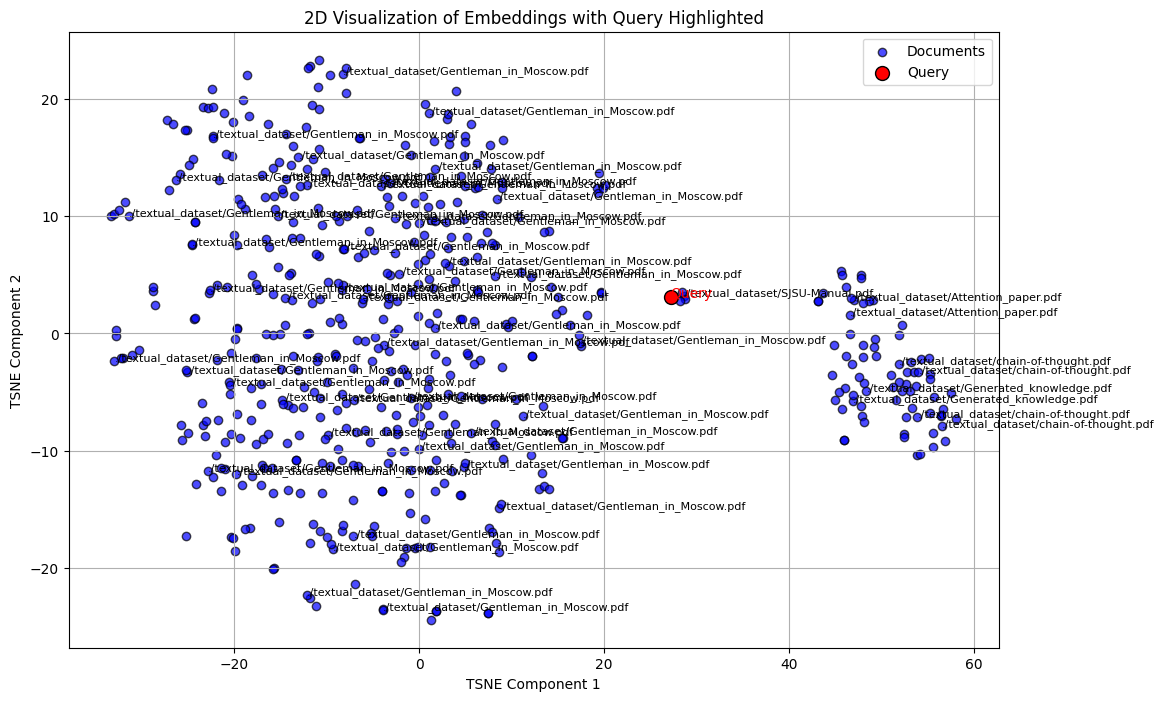

In [30]:
# Combine query embedding with document embeddings
all_embeddings = np.vstack([all_embeddings, query_embedding])
all_labels = all_metadata + [{"page": None, "source": "Query"}]

# Perform t-SNE again
tsne = TSNE(n_components=2, perplexity=min(30, len(all_embeddings) - 1), random_state=42, n_iter=1000)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot all embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:-1, 0], embeddings_2d[:-1, 1], c='blue', edgecolor='k', alpha=0.7, label='Documents')
plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1], c='red', edgecolor='k', s=100, label='Query')

# Annotate metadata
for i, metadata in enumerate(all_metadata):
    if i % 10 == 0:  # Avoid clutter by annotating every 10th point
        plt.annotate(metadata['source'], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

# Annotate query
plt.annotate("Query", (embeddings_2d[-1, 0], embeddings_2d[-1, 1]), fontsize=10, color='red')

plt.title("2D Visualization of Embeddings with Query Highlighted")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
import json 

# Load the persisted vector store
vectordb = Chroma(
    persist_directory="./textual_dataset_chromaDB",  # Directory where your vector store is saved
    embedding_function=OpenAIEmbeddings()  # Same embedding function
)

# Access the Chroma collection
collection = vectordb._collection

# Fetch all embeddings and metadata
data = collection.get(include=['embeddings', 'documents', 'metadatas'])
all_embeddings = np.array(data.get("embeddings", []))  # Extract embeddings as numpy array
all_metadata = data.get("metadatas", [])

# Validate embeddings
if all_embeddings.size == 0:
    raise ValueError("No embeddings found in the vector store.")

# Perform a query and get relevant embeddings
query = "What is the role of the Metropol Hotel staff in the story?"
retriever = vectordb.as_retriever(search_kwargs={"k": 5})  # Adjust k for the number of results
embedding_model = OpenAIEmbeddings()
query_embedding = embedding_model.embed_query(query)

C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


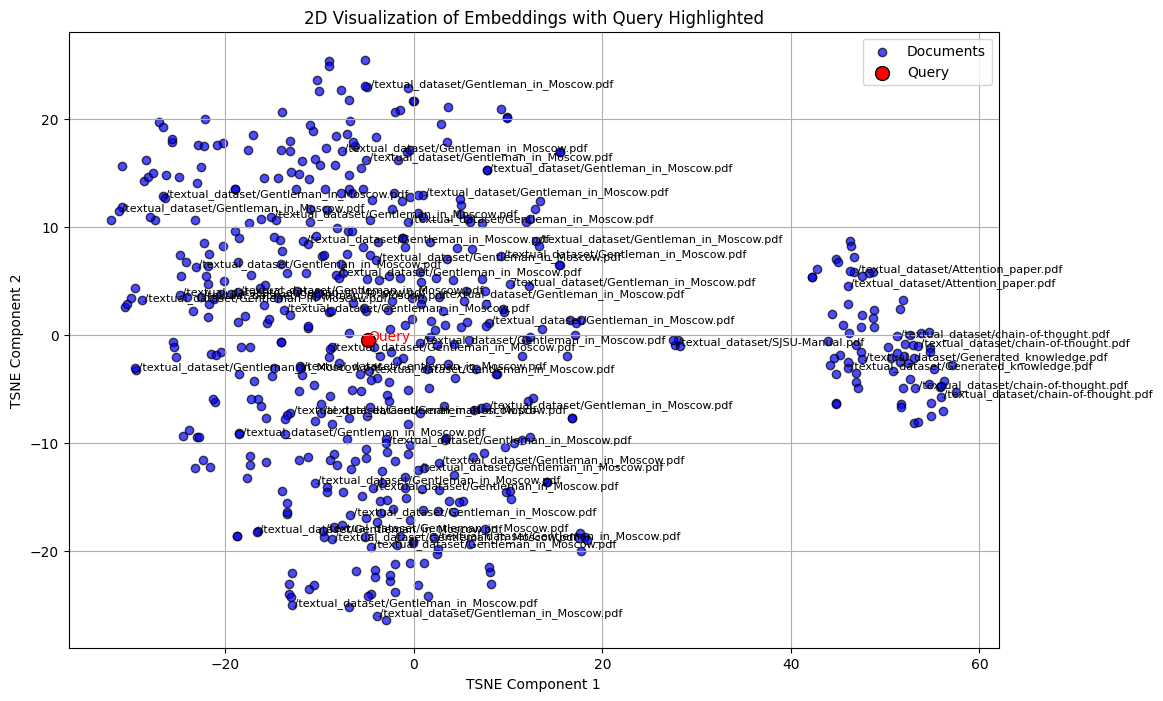

In [26]:
# Combine query embedding with document embeddings
all_embeddings = np.vstack([all_embeddings, query_embedding])
all_labels = all_metadata + [{"page": None, "source": "Query"}]

# Perform t-SNE again
tsne = TSNE(n_components=2, perplexity=min(30, len(all_embeddings) - 1), random_state=42, n_iter=1000)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot all embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:-1, 0], embeddings_2d[:-1, 1], c='blue', edgecolor='k', alpha=0.7, label='Documents')
plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1], c='red', edgecolor='k', s=100, label='Query')

# Annotate metadata
for i, metadata in enumerate(all_metadata):
    if i % 10 == 0:  # Avoid clutter by annotating every 10th point
        plt.annotate(metadata['source'], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

# Annotate query
plt.annotate("Query", (embeddings_2d[-1, 0], embeddings_2d[-1, 1]), fontsize=10, color='red')

plt.title("2D Visualization of Embeddings with Query Highlighted")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
import json 

# Load the persisted vector store
vectordb = Chroma(
    persist_directory="./textual_dataset_chromaDB",  # Directory where your vector store is saved
    embedding_function=OpenAIEmbeddings()  # Same embedding function
)

# Access the Chroma collection
collection = vectordb._collection

# Fetch all embeddings and metadata
data = collection.get(include=['embeddings', 'documents', 'metadatas'])
all_embeddings = np.array(data.get("embeddings", []))  # Extract embeddings as numpy array
all_metadata = data.get("metadatas", [])

# Validate embeddings
if all_embeddings.size == 0:
    raise ValueError("No embeddings found in the vector store.")

# Perform a query and get relevant embeddings
query = "How does GKP handle factuality in generated knowledge?"
retriever = vectordb.as_retriever(search_kwargs={"k": 5})  # Adjust k for the number of results
embedding_model = OpenAIEmbeddings()
query_embedding = embedding_model.embed_query(query)

C:\Users\charu\anaconda3\envs\RAG\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


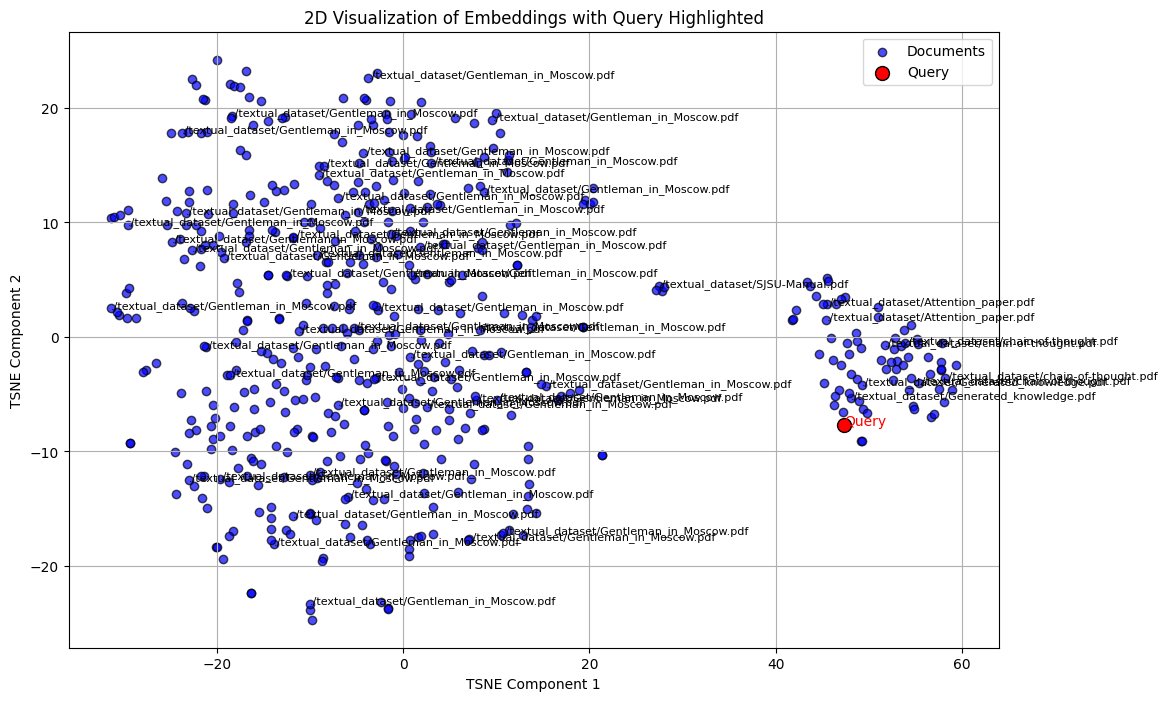

In [28]:
# Combine query embedding with document embeddings
all_embeddings = np.vstack([all_embeddings, query_embedding])
all_labels = all_metadata + [{"page": None, "source": "Query"}]

# Perform t-SNE again
tsne = TSNE(n_components=2, perplexity=min(30, len(all_embeddings) - 1), random_state=42, n_iter=1000)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot all embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:-1, 0], embeddings_2d[:-1, 1], c='blue', edgecolor='k', alpha=0.7, label='Documents')
plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1], c='red', edgecolor='k', s=100, label='Query')

# Annotate metadata
for i, metadata in enumerate(all_metadata):
    if i % 10 == 0:  # Avoid clutter by annotating every 10th point
        plt.annotate(metadata['source'], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

# Annotate query
plt.annotate("Query", (embeddings_2d[-1, 0], embeddings_2d[-1, 1]), fontsize=10, color='red')

plt.title("2D Visualization of Embeddings with Query Highlighted")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend()
plt.grid(True)
plt.show()
